In [26]:
import os, glob, pandas as pd, numpy as np
from sklearn.model_selection import GroupShuffleSplit
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns

ROOT = "../data"
print("CSV files:", glob.glob(os.path.join(ROOT, "csv", "*.csv")))


CSV files: ['../data/csv/calc_case_description_test_set.csv', '../data/csv/calc_case_description_train_set.csv', '../data/csv/dicom_info.csv', '../data/csv/mass_case_description_test_set.csv', '../data/csv/mass_case_description_train_set.csv', '../data/csv/meta.csv']


In [27]:
mass_train = pd.read_csv(f"{ROOT}/csv/mass_case_description_train_set.csv")
mass_train.head()


,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


Number of samples: 1318

Columns:
 Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'mass shape', 'mass margins',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')

Unique pathologies: ['MALIGNANT' 'BENIGN' 'BENIGN_WITHOUT_CALLBACK']


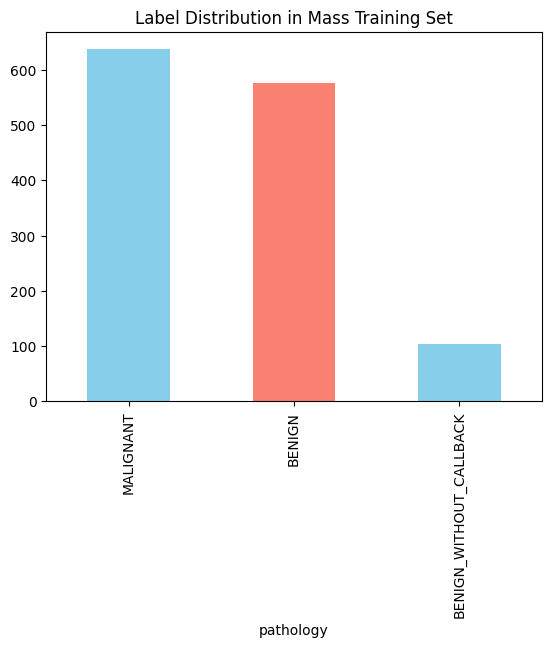

In [28]:
print("Number of samples:", len(mass_train))
print("\nColumns:\n", mass_train.columns)
print("\nUnique pathologies:", mass_train['pathology'].unique())

# Count of each label
mass_train['pathology'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Label Distribution in Mass Training Set')
plt.show()


Total samples: 3568


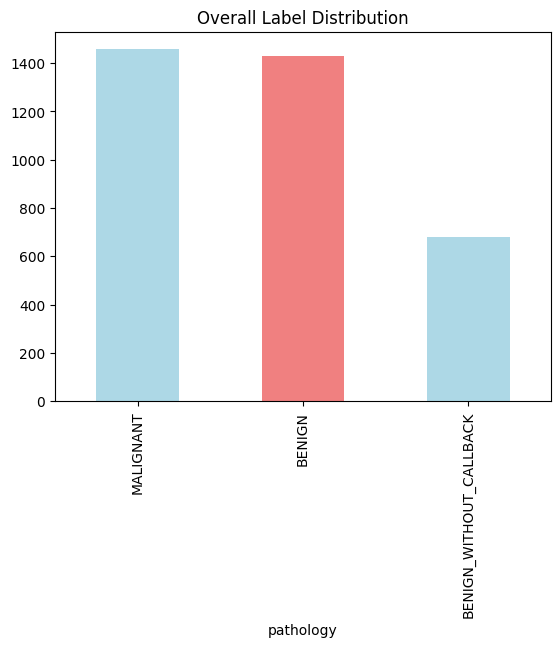

type  pathology              
calc  MALIGNANT                  673
      BENIGN                     658
      BENIGN_WITHOUT_CALLBACK    541
mass  MALIGNANT                  784
      BENIGN                     771
      BENIGN_WITHOUT_CALLBACK    141
Name: count, dtype: int64


In [29]:
mass = pd.concat([
    pd.read_csv(f"{ROOT}/csv/mass_case_description_train_set.csv"),
    pd.read_csv(f"{ROOT}/csv/mass_case_description_test_set.csv")
])
calc = pd.concat([
    pd.read_csv(f"{ROOT}/csv/calc_case_description_train_set.csv"),
    pd.read_csv(f"{ROOT}/csv/calc_case_description_test_set.csv")
])

mass['type'] = 'mass'
calc['type'] = 'calc'
df = pd.concat([mass, calc])

print("Total samples:", len(df))
df['pathology'].value_counts().plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Overall Label Distribution')
plt.show()

print(df.groupby('type')['pathology'].value_counts())


In [30]:
import os
print(os.listdir("../data")[:10])

# Helper function
def replace_path(series, old_path="CBIS-DDSM", new_path="../data"):
    return series.str.replace(old_path, new_path, regex=True).str.replace(".dcm", ".jpg")

# Apply this to your dataframe
df['cropped_image_fixed'] = replace_path(df['cropped image file path'])


['csv', 'jpeg']


In [31]:
print(df['cropped_image_fixed'].iloc[0])


Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/000000.jpg


In [32]:
import glob, os

# collect every .jpg file path
jpeg_paths = glob.glob(f"{ROOT}/jpeg/**/*jpg", recursive=True)

# map the DICOM-ID (the long number) → real .jpg path
jpeg_map = {}
for p in jpeg_paths:
    key = p.split('/')[3]           # the 6th element is the DICOM-ID
    jpeg_map[key] = p

print("Total JPEGs found:", len(jpeg_map))
# preview one mapping
list(jpeg_map.items())[:3]


Total JPEGs found: 6774


[('1.3.6.1.4.1.9590.100.1.2.100018879311824535125115145152454291132',
  '../data/jpeg/1.3.6.1.4.1.9590.100.1.2.100018879311824535125115145152454291132/2-241.jpg'),
 ('1.3.6.1.4.1.9590.100.1.2.100131208110604806117271735422083351547',
  '../data/jpeg/1.3.6.1.4.1.9590.100.1.2.100131208110604806117271735422083351547/1-126.jpg'),
 ('1.3.6.1.4.1.9590.100.1.2.100522099512256189513864912954167862869',
  '../data/jpeg/1.3.6.1.4.1.9590.100.1.2.100522099512256189513864912954167862869/1-231.jpg')]

In [33]:
def fix_cropped_path(old_path):
    """
    Convert broken DICOM paths to real .jpg paths in /jpeg folder.
    Returns None if not found.
    """
    try:
        key = old_path.split('/')[2]   # extract the DICOM-ID part
        return jpeg_map.get(key, None)
    except Exception:
        return None

df['cropped_image_fixed'] = df['cropped image file path'].apply(fix_cropped_path)

# check how many got fixed
print("Fixed paths:", df['cropped_image_fixed'].notna().sum())
print("Missing paths:", df['cropped_image_fixed'].isna().sum())
print("Example path:\n", df['cropped_image_fixed'].dropna().iloc[0])


Fixed paths: 3567
Missing paths: 1
Example path:
 ../data/jpeg/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/2-249.jpg


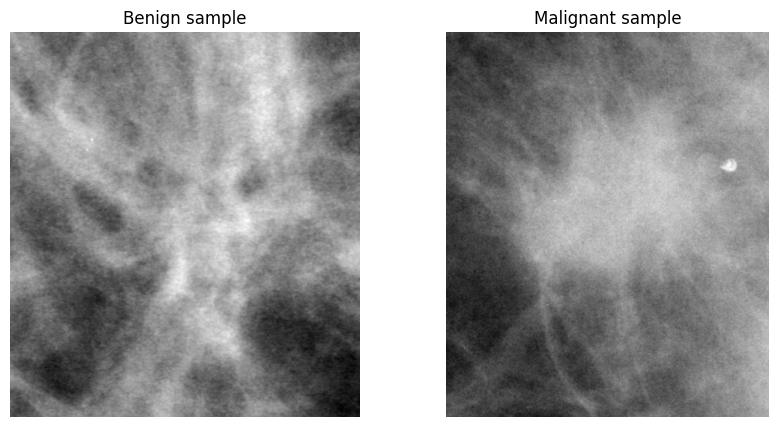

In [34]:
import cv2, matplotlib.pyplot as plt

def show_image(image_path, title=""):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("⚠️ Could not load image:", image_path)
        return
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')

benign = df[df['pathology'].str.contains('BENIGN', case=False)].iloc[0]
malig  = df[df['pathology'].str.contains('MALIG',  case=False)].iloc[0]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
show_image(benign['cropped_image_fixed'], "Benign sample")
plt.subplot(1,2,2)
show_image(malig['cropped_image_fixed'], "Malignant sample")
plt.show()


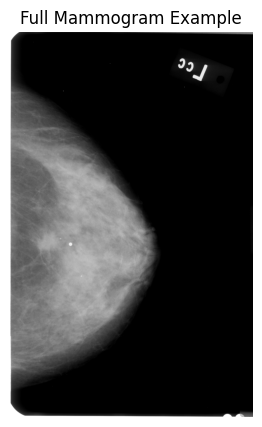

In [35]:
def fix_full_path(old_path):
    try:
        key = old_path.split('/')[2]
        return jpeg_map.get(key, None)
    except Exception:
        return None

df['full_image_fixed'] = df['image file path'].apply(fix_full_path)
plt.figure(figsize=(10,5))
show_image(df['full_image_fixed'].dropna().iloc[0], "Full Mammogram Example")


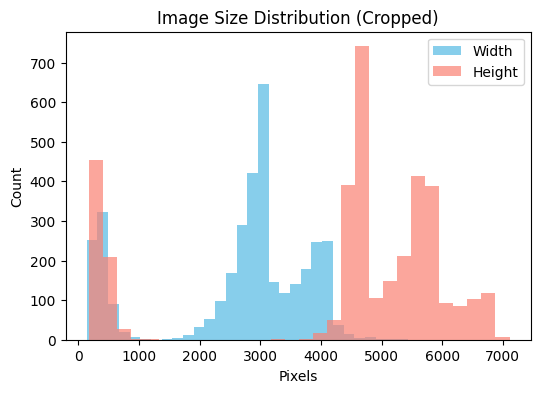

In [36]:
#Check image size distribution
import cv2

def get_size(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return (None, None)
    return img.shape[:2]  # (height, width)

sizes = df['cropped_image_fixed'].dropna().apply(get_size)
heights, widths = zip(*sizes)

plt.figure(figsize=(6,4))
plt.hist(widths, bins=30, color='skyblue', label='Width')
plt.hist(heights, bins=30, color='salmon', alpha=0.7, label='Height')
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.legend()
plt.title("Image Size Distribution (Cropped)")
plt.show()


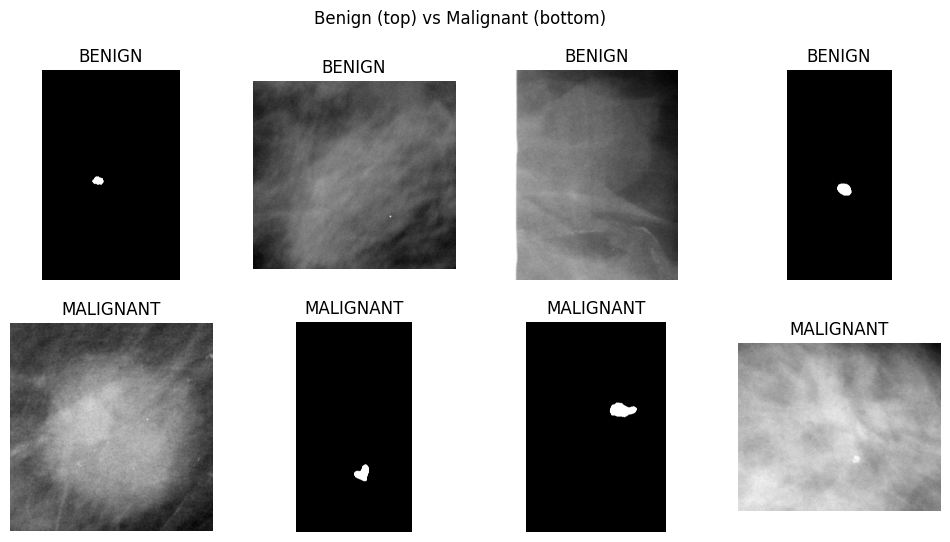

In [37]:
#Show a small grid of benign vs malignant examples:
import random

plt.figure(figsize=(12,6))
benigns = df[df['pathology'].str.contains('BENIGN', case=False)].sample(4, random_state=1)
maligs  = df[df['pathology'].str.contains('MALIG',  case=False)].sample(4, random_state=2)

for i, row in enumerate(pd.concat([benigns, maligs]).itertuples()):
    plt.subplot(2,4,i+1)
    show_image(row.cropped_image_fixed, row.pathology)
plt.suptitle("Benign (top) vs Malignant (bottom)")
plt.show()


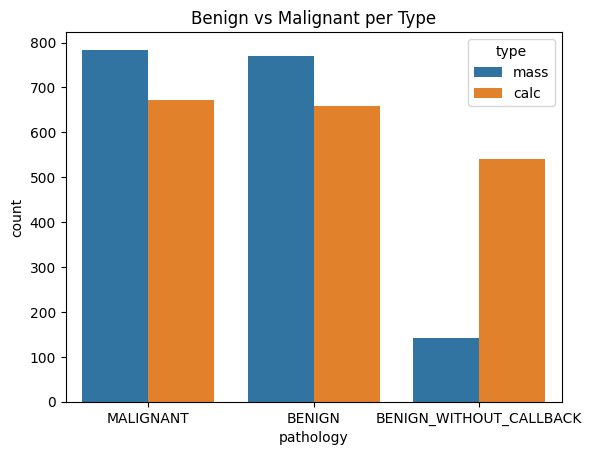

In [38]:
#mass vs calcification
sns.countplot(x='pathology', hue='type', data=df)
plt.title("Benign vs Malignant per Type")
plt.show()


In [39]:
df['label'] = df['pathology'].apply(lambda x: 1 if 'MALIGNANT' in x else 0)
#It converts your 3 pathology labels into a single binary target:
#1 → Malignant (cancer)
#0 → Benign (no cancer)

In [40]:
missing = df[df['cropped_image_fixed'].isna()]
print("❌ Missing image paths:", len(missing))
print(missing[['pathology', 'cropped image file path']].head())


❌ Missing image paths: 1
                    pathology  \
1216  BENIGN_WITHOUT_CALLBACK   

                                cropped image file path  
1216  Calc-Training_P_01563_RIGHT_MLO_2/1.3.6.1.4.1....  


In [41]:
df = df[df['cropped_image_fixed'].notna()].reset_index(drop=True)
print("✅ Remaining valid samples:", len(df))

✅ Remaining valid samples: 3567


In [42]:
# Check label balance
print(df['pathology'].value_counts())
print(df['label'].value_counts())

# Check for wrong/missing images
bad = df[~df['cropped_image_fixed'].apply(lambda x: os.path.exists(x))]
print("Missing files:", len(bad))


pathology
MALIGNANT                  1457
BENIGN                     1429
BENIGN_WITHOUT_CALLBACK     681
Name: count, dtype: int64
label
0    2110
1    1457
Name: count, dtype: int64
Missing files: 0


In [43]:
#train/validation split
from sklearn.model_selection import GroupShuffleSplit

# Use patient_id to avoid leakage
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(df, groups=df["patient_id"]))

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df = df.iloc[val_idx].reset_index(drop=True)

print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))
print("Malignant ratio in train:", train_df['label'].mean())
print("Malignant ratio in val:", val_df['label'].mean())


Train samples: 2873
Validation samples: 694
Malignant ratio in train: 0.4152453880960668
Malignant ratio in val: 0.3804034582132565


In [44]:
import tensorflow as tf

IMG_SIZE = 512   # standard for mammograms (you can try 256 if GPU is small)
BATCH_SIZE = 8
AUTO = tf.data.AUTOTUNE

# Load and preprocess a single image
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=1)       # grayscale
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.image.convert_image_dtype(img, tf.float32)  # scale to [0,1]
    return img, tf.cast(label, tf.float32)

# Simple augmentation (horizontal flip, brightness, contrast)
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.05)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, label

In [45]:
def make_dataset(dataframe, training=True):
    ds = tf.data.Dataset.from_tensor_slices((dataframe['cropped_image_fixed'], dataframe['label']))
    ds = ds.map(load_image, num_parallel_calls=AUTO)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTO)
        ds = ds.shuffle(512, reshuffle_each_iteration=True)
    return ds.batch(BATCH_SIZE).prefetch(AUTO)

train_ds = make_dataset(train_df, training=True)
val_ds   = make_dataset(val_df, training=False)


In [46]:
for images, labels in train_ds.take(1):
    print("✅ batch shape:", images.shape, labels.numpy())

✅ batch shape: (8, 512, 512, 1) [1. 0. 1. 0. 1. 0. 0. 1.]


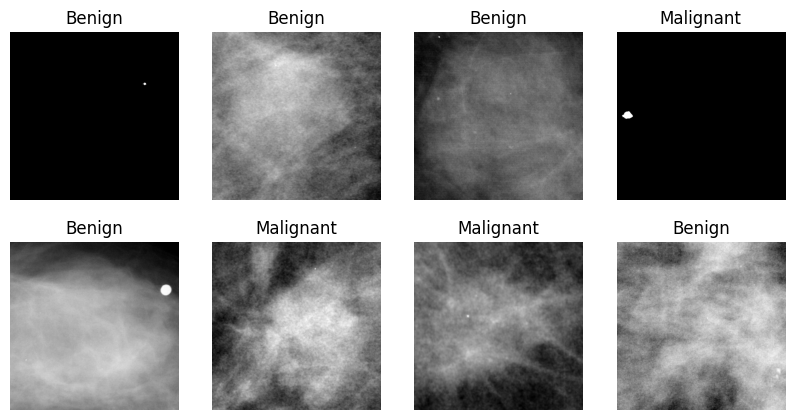

In [47]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10,5))
    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.imshow(tf.squeeze(images[i]), cmap='gray')
        plt.title("Malignant" if labels[i]==1 else "Benign")
        plt.axis('off')
    plt.show()


In [48]:
from tensorflow.keras import layers, models

def build_cnn(input_shape=(512, 512, 1)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(256, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')  # binary classification
    ])
    return model

cnn = build_cnn()
cnn.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 510, 510, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 255, 255, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 126, 126, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 62, 62, 128)      

In [49]:
cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)


In [50]:
import os

# Create model directory if it doesn't exist
MODEL_DIR = "../models"
os.makedirs(MODEL_DIR, exist_ok=True)
print(f"Models will be saved to: {MODEL_DIR}")

Models will be saved to: ../models


In [51]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(os.path.join(MODEL_DIR, "best_cnn.keras"), save_best_only=True, monitor='val_auc', mode='max'),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_auc', mode='max', restore_best_weights=True)
]

history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
360/360 [==============================] - 81s 223ms/step - loss: 1.5015 - accuracy: 0.5844 - auc: 0.5690 - val_loss: 0.6700 - val_accuracy: 0.6167 - val_auc: 0.5607
Epoch 2/15
360/360 [==============================] - 81s 224ms/step - loss: 0.6317 - accuracy: 0.6387 - auc: 0.6688 - val_loss: 0.7822 - val_accuracy: 0.6182 - val_auc: 0.5846
Epoch 3/15
360/360 [==============================] - 81s 222ms/step - loss: 0.6126 - accuracy: 0.6565 - auc: 0.7082 - val_loss: 0.6795 - val_accuracy: 0.6095 - val_auc: 0.5739
Epoch 4/15
360/360 [==============================] - 81s 222ms/step - loss: 0.5438 - accuracy: 0.7202 - auc: 0.7878 - val_loss: 0.7205 - val_accuracy: 0.6066 - val_auc: 0.5715
Epoch 5/15
360/360 [==============================] - 80s 221ms/step - loss: 0.4899 - accuracy: 0.7442 - auc: 0.8321 - val_loss: 0.7381 - val_accuracy: 0.5951 - val_auc: 0.5591
Epoch 6/15
360/360 [==============================] - 79s 218ms/step - loss: 0.4345 - accuracy: 0.7811 - auc: 0.873

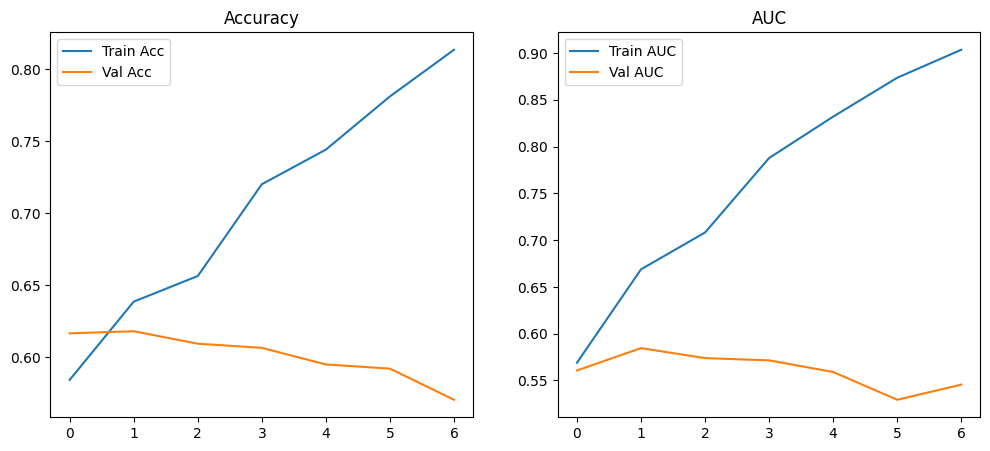

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC')
plt.legend()
plt.show()


In [53]:
cnn.evaluate(val_ds)


87/87 [==============================] - 8s 87ms/step - loss: 0.7822 - accuracy: 0.6182 - auc: 0.5846


[0.78221195936203, 0.6181555986404419, 0.5846107006072998]

In [54]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score

y_true, y_pred = [], []
for imgs, labels in val_ds:
    preds = cnn.predict(imgs)
    y_pred.extend(preds.ravel())
    y_true.extend(labels.numpy())

y_pred_bin = np.array(y_pred) > 0.5
print("AUC:", roc_auc_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_bin))


1/1 [==============================] - 0s 90ms/step
AUC: 0.5848220577871741
Confusion Matrix:
 [[332  98]
 [167  97]]


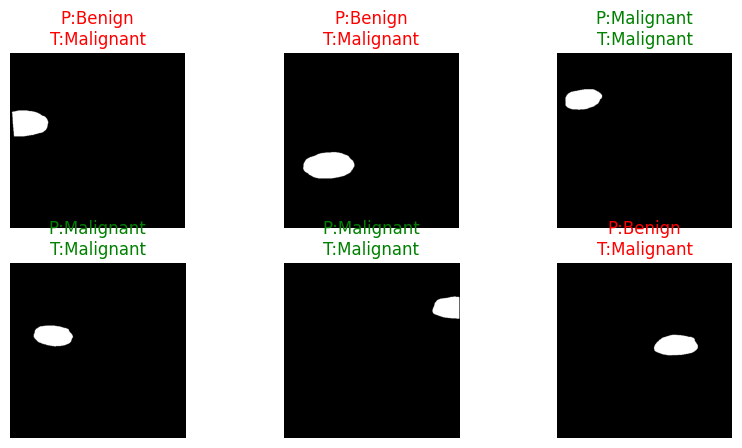

In [55]:
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(tf.squeeze(imgs[i]), cmap='gray')
    pred = "Malignant" if y_pred_bin[i] else "Benign"
    true = "Malignant" if labels[i]==1 else "Benign"
    color = "red" if pred != true else "green"
    plt.title(f"P:{pred}\nT:{true}", color=color)
    plt.axis('off')
plt.show()


In [56]:
def to_rgb(img, label):
    img = tf.image.grayscale_to_rgb(img)
    return img, label

train_rgb = train_ds.map(to_rgb)
val_rgb = val_ds.map(to_rgb)


In [57]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

base = EfficientNetB0(
    include_top=False,
    input_shape=(512, 512, 3),
    weights="imagenet"
)

# freeze base initially
base.trainable = False

inputs = layers.Input((512, 512, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)


In [58]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(os.path.join(MODEL_DIR, "best_efficientnet.keras"),
                                       save_best_only=True,
                                       monitor="val_auc",
                                       mode="max"),
    tf.keras.callbacks.EarlyStopping(patience=4,
                                     monitor="val_auc",
                                     mode="max",
                                     restore_best_weights=True)
]

history = model.fit(
    train_rgb,
    validation_data=val_rgb,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
360/360 [==============================] - 123s 331ms/step - loss: 0.6831 - accuracy: 0.5795 - auc: 0.5205 - val_loss: 0.6534 - val_accuracy: 0.6340 - val_auc: 0.6076
Epoch 2/10
360/360 [==============================] - 118s 327ms/step - loss: 0.6639 - accuracy: 0.5935 - auc: 0.6022 - val_loss: 0.6376 - val_accuracy: 0.6455 - val_auc: 0.6630
Epoch 3/10
360/360 [==============================] - 119s 328ms/step - loss: 0.6551 - accuracy: 0.6091 - auc: 0.6284 - val_loss: 0.6283 - val_accuracy: 0.6599 - val_auc: 0.6721
Epoch 4/10
360/360 [==============================] - 120s 332ms/step - loss: 0.6451 - accuracy: 0.6164 - auc: 0.6554 - val_loss: 0.6211 - val_accuracy: 0.6715 - val_auc: 0.6762
Epoch 5/10
360/360 [==============================] - 119s 330ms/step - loss: 0.6367 - accuracy: 0.6251 - auc: 0.6695 - val_loss: 0.6165 - val_accuracy: 0.6671 - val_auc: 0.6793
Epoch 6/10
360/360 [==============================] - 118s 327ms/step - loss: 0.6325 - accuracy: 0.6338 - auc:

In [59]:
print("Final training accuracy:", history.history['accuracy'][-1])
print("Final validation accuracy:", history.history['val_accuracy'][-1])
print("Final training AUC:", history.history['auc'][-1])
print("Final validation AUC:", history.history['val_auc'][-1])


Final training accuracy: 0.6481029987335205
Final validation accuracy: 0.6858789920806885
Final training AUC: 0.6867141723632812
Final validation AUC: 0.6882091760635376


In [60]:
results = model.evaluate(val_rgb)
print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")
print(f"AUC: {results[2]:.4f}")


87/87 [==============================] - 23s 262ms/step - loss: 0.6038 - accuracy: 0.6859 - auc: 0.6882
Loss: 0.6038
Accuracy: 0.6859
AUC: 0.6882


In [61]:
# Unfreeze base model
base.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # smaller LR for fine-tuning
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

history_ft = model.fit(
    train_rgb,
    validation_data=val_rgb,
    epochs=5,
    callbacks=callbacks
)


Epoch 1/5
360/360 [==============================] - 302s 807ms/step - loss: 0.6192 - accuracy: 0.6471 - auc: 0.6905 - val_loss: 0.6042 - val_accuracy: 0.6744 - val_auc: 0.7034
Epoch 2/5
360/360 [==============================] - 287s 796ms/step - loss: 0.6073 - accuracy: 0.6728 - auc: 0.7117 - val_loss: 0.5958 - val_accuracy: 0.6671 - val_auc: 0.7196
Epoch 3/5
360/360 [==============================] - 285s 790ms/step - loss: 0.5979 - accuracy: 0.6704 - auc: 0.7220 - val_loss: 0.5908 - val_accuracy: 0.6787 - val_auc: 0.7228
Epoch 4/5
360/360 [==============================] - 284s 788ms/step - loss: 0.5875 - accuracy: 0.6773 - auc: 0.7362 - val_loss: 0.5880 - val_accuracy: 0.6758 - val_auc: 0.7273
Epoch 5/5
360/360 [==============================] - 282s 783ms/step - loss: 0.5824 - accuracy: 0.6954 - auc: 0.7450 - val_loss: 0.5892 - val_accuracy: 0.6916 - val_auc: 0.7392


In [62]:
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.1)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_rotation(img, 0.1)
    return img, label


In [63]:
print("Final training accuracy:", history_ft.history['accuracy'][-1])
print("Final validation accuracy:", history_ft.history['val_accuracy'][-1])
print("Final training AUC:", history_ft.history['auc'][-1])
print("Final validation AUC:", history_ft.history['val_auc'][-1])


Final training accuracy: 0.6954402923583984
Final validation accuracy: 0.6916426420211792
Final training AUC: 0.7450083494186401
Final validation AUC: 0.7392265200614929


In [64]:
df['cropped_image_fixed'] = df['ROI mask file path']


In [65]:
import tensorflow as tf
import numpy as np
import cv2

IMG_SIZE = 512
BATCH_SIZE = 4          # smaller batch for stability
AUTO = tf.data.AUTOTUNE


In [66]:
def clahe_preprocess(path):
    img = cv2.imread(path.decode(), cv2.IMREAD_GRAYSCALE)
    # gentler contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(4,4))
    img = clahe.apply(img)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype(np.float32) / 255.0
    return img

def load_image_with_clahe(path, label):
    img = tf.numpy_function(clahe_preprocess, [path], tf.float32)
    img.set_shape((IMG_SIZE, IMG_SIZE, 3))
    return img, tf.cast(label, tf.float32)


In [67]:
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.05)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, label


In [68]:
def make_dataset(dataframe, training=True):
    ds = tf.data.Dataset.from_tensor_slices((dataframe['cropped_image_fixed'], dataframe['label']))
    ds = ds.map(load_image_with_clahe, num_parallel_calls=AUTO)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTO)
        ds = ds.shuffle(512, reshuffle_each_iteration=True)
    return ds.batch(BATCH_SIZE).prefetch(AUTO)

train_ds = make_dataset(train_df, training=True)
val_ds   = make_dataset(val_df, training=False)

train_rgb = train_ds
val_rgb = val_ds


In [69]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models

base = EfficientNetB3(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))
base.trainable = False  # freeze base at first

inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = models.Model(inputs, outputs)


In [70]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(os.path.join(MODEL_DIR, "best_b3.keras"), save_best_only=True, monitor="val_auc", mode="max"),
    tf.keras.callbacks.EarlyStopping(patience=4, monitor="val_auc", mode="max", restore_best_weights=True)
]

history = model.fit(train_rgb, validation_data=val_rgb, epochs=8, callbacks=callbacks)


Epoch 1/8
719/719 [==============================] - 354s 482ms/step - loss: 0.6816 - accuracy: 0.5684 - auc: 0.5370 - val_loss: 0.6658 - val_accuracy: 0.6196 - val_auc: 0.5091
Epoch 2/8
719/719 [==============================] - 347s 479ms/step - loss: 0.6841 - accuracy: 0.5649 - auc: 0.5261 - val_loss: 0.6643 - val_accuracy: 0.6196 - val_auc: 0.5337
Epoch 3/8
719/719 [==============================] - 344s 475ms/step - loss: 0.6856 - accuracy: 0.5823 - auc: 0.5158 - val_loss: 0.6662 - val_accuracy: 0.6196 - val_auc: 0.5125
Epoch 4/8
719/719 [==============================] - 344s 474ms/step - loss: 0.6837 - accuracy: 0.5806 - auc: 0.5201 - val_loss: 0.6640 - val_accuracy: 0.6196 - val_auc: 0.5193
Epoch 5/8
719/719 [==============================] - 344s 474ms/step - loss: 0.6855 - accuracy: 0.5740 - auc: 0.5222 - val_loss: 0.6641 - val_accuracy: 0.6196 - val_auc: 0.5337
Epoch 6/8
719/719 [==============================] - 343s 474ms/step - loss: 0.6851 - accuracy: 0.5736 - auc: 0.521

In [71]:
base.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),  # smaller learning rate for fine-tuning
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

history_ft = model.fit(train_rgb, validation_data=val_rgb, epochs=8, callbacks=callbacks)


Epoch 1/8
719/719 [==============================] - 727s 984ms/step - loss: 0.6807 - accuracy: 0.5743 - auc: 0.5359 - val_loss: 0.6642 - val_accuracy: 0.6196 - val_auc: 0.5847
Epoch 2/8
719/719 [==============================] - 703s 973ms/step - loss: 0.6817 - accuracy: 0.5778 - auc: 0.5314 - val_loss: 0.6629 - val_accuracy: 0.6196 - val_auc: 0.5865
Epoch 3/8
719/719 [==============================] - 704s 976ms/step - loss: 0.6814 - accuracy: 0.5726 - auc: 0.5285 - val_loss: 0.6608 - val_accuracy: 0.6196 - val_auc: 0.6081
Epoch 4/8
719/719 [==============================] - 703s 974ms/step - loss: 0.6814 - accuracy: 0.5680 - auc: 0.5250 - val_loss: 0.6559 - val_accuracy: 0.6254 - val_auc: 0.6300
Epoch 5/8
719/719 [==============================] - 709s 982ms/step - loss: 0.6696 - accuracy: 0.5990 - auc: 0.5747 - val_loss: 0.6475 - val_accuracy: 0.6441 - val_auc: 0.6300
Epoch 6/8
719/719 [==============================] - 703s 974ms/step - loss: 0.6623 - accuracy: 0.6015 - auc: 0.594

In [72]:
val_loss, val_acc, val_auc = model.evaluate(val_rgb)
print(f"📊 Validation Accuracy: {val_acc:.4f}")
print(f"📈 Validation AUC: {val_auc:.4f}")


174/174 [==============================] - 66s 380ms/step - loss: 0.6428 - accuracy: 0.6657 - auc: 0.6232
📊 Validation Accuracy: 0.6657
📈 Validation AUC: 0.6232


In [73]:
# TransUNet Implementation
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

def mlp(x, hidden_units, dropout_rate):
    """Multi-layer perceptron for Transformer blocks."""
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def transformer_encoder_block(x, num_heads, projection_dim, transformer_units, dropout_rate):
    """Transformer encoder block implementation."""
    # Layer normalization 1
    x1 = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Multi-head self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate
    )(x1, x1)
    
    # Skip connection 1
    x2 = layers.Add()([attention_output, x])
    
    # Layer normalization 2
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    
    # MLP
    mlp_output = mlp(x3, transformer_units, dropout_rate)
    
    # Skip connection 2
    return layers.Add()([mlp_output, x2])

def positional_encoding(length, depth):
    """Generate positional encoding for transformer."""
    depth = depth / 2
    
    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth   # (1, depth)
     
    angle_rates = 1 / (10000**depths)                # (1, depth)
    angle_rads = positions * angle_rates             # (pos, depth)
    
    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)], axis=-1) 
    
    return tf.cast(pos_encoding, dtype=tf.float32)

def double_conv_block(x, n_filters):
    """Double convolution block for U-Net."""
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    return x

def downsample_block(x, n_filters):
    """Downsample block for U-Net encoder."""
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    """Upsample block for U-Net decoder."""
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

def build_transunet(
    input_shape=(512, 512, 3),
    patch_size=16,
    num_patches=1024,
    projection_dim=128,
    num_heads=8,
    transformer_units=None,
    transformer_layers=12,
    dropout_rate=0.1,
):
    # Set default transformer units if none provided
    if transformer_units is None:
        transformer_units = [projection_dim * 2, projection_dim]
    """Build TransUNet model - combining Transformer with U-Net architecture."""
    inputs = layers.Input(input_shape)
    
    # U-Net encoder pathway with skip connections
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    
    # Middle block using Transformer
    # First convert image features to patches
    # Assuming p4 has shape (batch_size, height, width, channels)
    p4_height, p4_width = p4.shape[1], p4.shape[2]
    
    # Extract patches
    patches = layers.Conv2D(
        filters=projection_dim, 
        kernel_size=patch_size, 
        strides=patch_size, 
        padding="valid",
    )(p4)
    
    # Reshape patches: (batch_size, num_patches, projection_dim)
    patch_dims = patches.shape[1] * patches.shape[2]
    patches = layers.Reshape((patch_dims, projection_dim))(patches)
    
    # Add positional embedding
    positions = positional_encoding(patch_dims, projection_dim)
    patches = patches + positions
    
    # Apply transformer blocks
    encoded_patches = patches
    for _ in range(transformer_layers):
        encoded_patches = transformer_encoder_block(
            encoded_patches, num_heads, projection_dim, transformer_units, dropout_rate
        )
    
    # Reshape back to feature map
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Reshape((int(np.sqrt(patch_dims)), int(np.sqrt(patch_dims)), projection_dim))(representation)
    
    # Convert back to original feature map size
    representation = layers.Conv2DTranspose(512, 3, strides=patch_size, padding="same")(representation)
    representation = layers.Resizing(p4_height, p4_width)(representation)
    
    # Bridge between transformer and U-Net decoder
    bridge = layers.Concatenate()([p4, representation])
    
    # U-Net decoder pathway
    u6 = upsample_block(bridge, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    
    # Final convolution layer
    x = layers.Conv2D(1, 1, padding="same", activation=None)(u9)
    
    # Global average pooling to get a single value per image for binary classification
    x = layers.GlobalAveragePooling2D()(x)
    
    # Output layer with sigmoid activation for binary classification
    outputs = layers.Activation('sigmoid')(x)
    
    # Create the model
    model = models.Model(inputs, outputs)
    
    return model

In [74]:
# Instantiate and compile TransUNet model
# Adjust parameters based on your data and GPU constraints
transunet_model = build_transunet(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    patch_size=16,  
    projection_dim=128,
    num_heads=4,
    transformer_layers=4,  # Reduce for faster training
    transformer_units=None,  # Will use default from function
    dropout_rate=0.2
)

transunet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

transunet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 512, 512, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d_8[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 conv2d_9 (Conv2D)           (None, 512, 512, 64)         36928     ['batch_normalization[0]

In [75]:
# Fix the TransUNet model to ensure it outputs a shape that matches the labels

# First, let's define a completely new version of the build_transunet function
def build_transunet_binary(
    input_shape=(512, 512, 3),
    patch_size=16,
    num_patches=1024,
    projection_dim=128,
    num_heads=8,
    transformer_units=None,
    transformer_layers=12,
    dropout_rate=0.1,
):
    # Set default transformer units if none provided
    if transformer_units is None:
        transformer_units = [projection_dim * 2, projection_dim]
        
    """Build TransUNet model for binary classification."""
    inputs = layers.Input(input_shape)
    
    # U-Net encoder pathway with skip connections
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    
    # Middle block using Transformer
    # Assuming p4 has shape (batch_size, height, width, channels)
    p4_height, p4_width = p4.shape[1], p4.shape[2]
    
    # Extract patches
    patches = layers.Conv2D(
        filters=projection_dim, 
        kernel_size=patch_size, 
        strides=patch_size, 
        padding="valid",
    )(p4)
    
    # Reshape patches: (batch_size, num_patches, projection_dim)
    patch_dims = patches.shape[1] * patches.shape[2]
    patches = layers.Reshape((patch_dims, projection_dim))(patches)
    
    # Add positional embedding
    positions = positional_encoding(patch_dims, projection_dim)
    patches = layers.add([patches, positions])
    
    # Apply transformer blocks
    encoded_patches = patches
    for _ in range(transformer_layers):
        encoded_patches = transformer_encoder_block(
            encoded_patches, num_heads, projection_dim, transformer_units, dropout_rate
        )
    
    # Reshape back to feature map
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Reshape((int(np.sqrt(patch_dims)), int(np.sqrt(patch_dims)), projection_dim))(representation)
    
    # Convert back to original feature map size
    representation = layers.Conv2DTranspose(512, 3, strides=patch_size, padding="same")(representation)
    representation = layers.Resizing(p4_height, p4_width)(representation)
    
    # Bridge between transformer and U-Net decoder
    bridge = layers.concatenate([p4, representation])
    
    # U-Net decoder pathway
    u6 = upsample_block(bridge, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    
    # Use global average pooling to reduce to a single prediction per image
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(u9)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    # Create the model
    model = models.Model(inputs, outputs)
    
    return model

# Create a new instance of the TransUNet model
transunet_model = build_transunet_binary(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    patch_size=16,  
    projection_dim=128,
    num_heads=4,
    transformer_layers=4,
    transformer_units=None,
    dropout_rate=0.2
)

# Compile the model
transunet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

# Display the model summary and check output shape
print("Model output shape:", transunet_model.output_shape)
print("\nModel Summary:")
transunet_model.summary()

Model output shape: (4, 1)

Model Summary:
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 512, 512, 64)         1792      ['input_6[0][0]']             
                                                                                                  
 batch_normalization_16 (Ba  (None, 512, 512, 64)         256       ['conv2d_26[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_27 (Conv2D)          (None, 512, 512, 64)

In [76]:
# Reinitialize the TransUNet model with the corrected architecture
transunet_model = build_transunet(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    patch_size=16,  
    projection_dim=128,
    num_heads=4,
    transformer_layers=4,  # Reduce for faster training
    transformer_units=None,  # Will use default from function
    dropout_rate=0.2
)

transunet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

# Check the model output shape to verify it's (None, 1) as required
print("Model output shape:", transunet_model.output_shape)

Model output shape: (None, 1)


In [77]:
# Train the TransUNet model
transunet_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, "best_transunet.keras"), 
        save_best_only=True, 
        monitor="val_auc", 
        mode="max"
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=4, 
        monitor="val_auc", 
        mode="max", 
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=2,
        min_lr=1e-6
    )
]

# Train the model with a smaller batch size if needed
transunet_history = transunet_model.fit(
    train_rgb,
    validation_data=val_rgb,
    epochs=10,  # Adjust based on convergence
    batch_size=2,  # Smaller batch size due to model complexity
    callbacks=transunet_callbacks
)

Epoch 1/10
719/719 [==============================] - 2100s 3s/step - loss: 0.6869 - accuracy: 0.5694 - auc: 0.5608 - val_loss: 1.2559 - val_accuracy: 0.6427 - val_auc: 0.6303 - lr: 1.0000e-04
Epoch 2/10
719/719 [==============================] - 2113s 3s/step - loss: 0.6689 - accuracy: 0.6098 - auc: 0.5862 - val_loss: 1.3676 - val_accuracy: 0.6427 - val_auc: 0.6310 - lr: 1.0000e-04
Epoch 3/10
719/719 [==============================] - 2108s 3s/step - loss: 0.6649 - accuracy: 0.6091 - auc: 0.5941 - val_loss: 1.7088 - val_accuracy: 0.6340 - val_auc: 0.6310 - lr: 1.0000e-04
Epoch 4/10
719/719 [==============================] - 2112s 3s/step - loss: 0.6577 - accuracy: 0.6196 - auc: 0.6122 - val_loss: 1.1148 - val_accuracy: 0.6239 - val_auc: 0.6323 - lr: 2.0000e-05
Epoch 5/10
719/719 [==============================] - 2141s 3s/step - loss: 0.6542 - accuracy: 0.6161 - auc: 0.6266 - val_loss: 1.2874 - val_accuracy: 0.6239 - val_auc: 0.6319 - lr: 2.0000e-05
Epoch 6/10
719/719 [===============

In [78]:
# Evaluate TransUNet model
val_loss, val_acc, val_auc = transunet_model.evaluate(val_rgb)
print(f"TransUNet Validation Results:")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_acc:.4f}")
print(f"AUC: {val_auc:.4f}")

174/174 [==============================] - 154s 884ms/step - loss: 1.1816 - accuracy: 0.6254 - auc: 0.6316
TransUNet Validation Results:
Loss: 1.1816
Accuracy: 0.6254
AUC: 0.6316


In [79]:
# List saved models
import os
import glob

saved_models = glob.glob(os.path.join(MODEL_DIR, "*.keras"))
print(f"Saved models in {MODEL_DIR}:")
for model_path in saved_models:
    model_name = os.path.basename(model_path)
    model_size = os.path.getsize(model_path) / (1024 * 1024)  # Convert to MB
    print(f"- {model_name} ({model_size:.2f} MB)")

Saved models in ../models:
- best_b3.keras (124.14 MB)
- best_cnn.keras (342.00 MB)
- best_efficientnet.keras (46.91 MB)
- best_transunet.keras (447.41 MB)


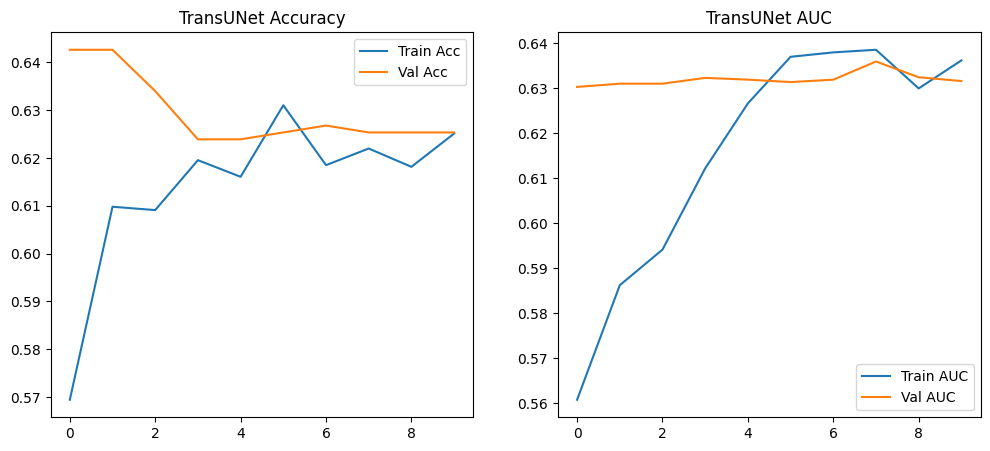

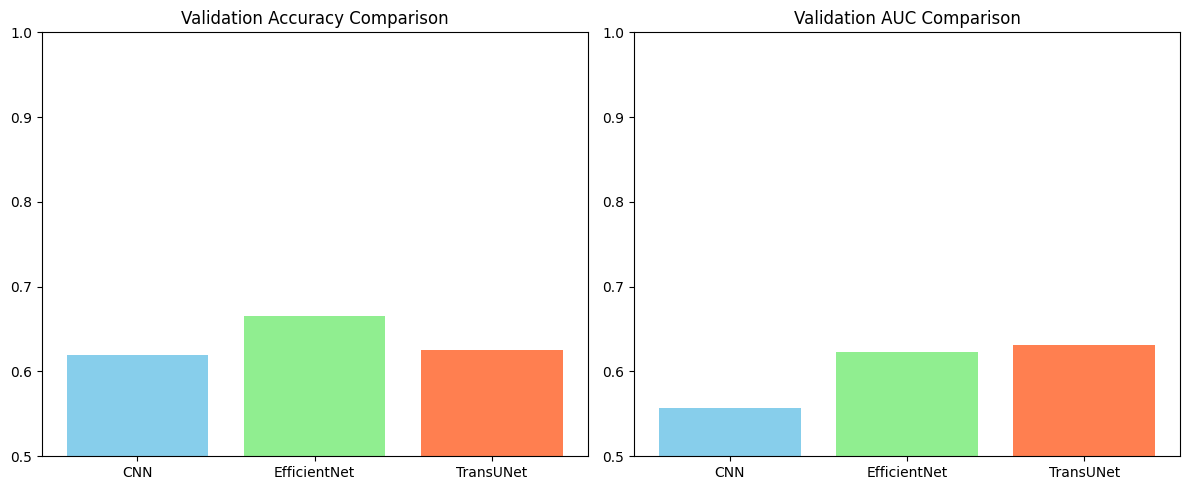

In [80]:
# Plot TransUNet training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(transunet_history.history['accuracy'], label='Train Acc')
plt.plot(transunet_history.history['val_accuracy'], label='Val Acc')
plt.title('TransUNet Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(transunet_history.history['auc'], label='Train AUC')
plt.plot(transunet_history.history['val_auc'], label='Val AUC')
plt.title('TransUNet AUC')
plt.legend()
plt.show()

# Compare model performance
model_names = ['CNN', 'EfficientNet', 'TransUNet']
accuracies = [history.history['val_accuracy'][-1], history_ft.history['val_accuracy'][-1], transunet_history.history['val_accuracy'][-1]]
aucs = [history.history['val_auc'][-1], history_ft.history['val_auc'][-1], transunet_history.history['val_auc'][-1]]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'coral'])
plt.title('Validation Accuracy Comparison')
plt.ylim(0.5, 1.0)

plt.subplot(1,2,2)
plt.bar(model_names, aucs, color=['skyblue', 'lightgreen', 'coral'])
plt.title('Validation AUC Comparison')
plt.ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

1/1 [==============================] - 1s 1s/step


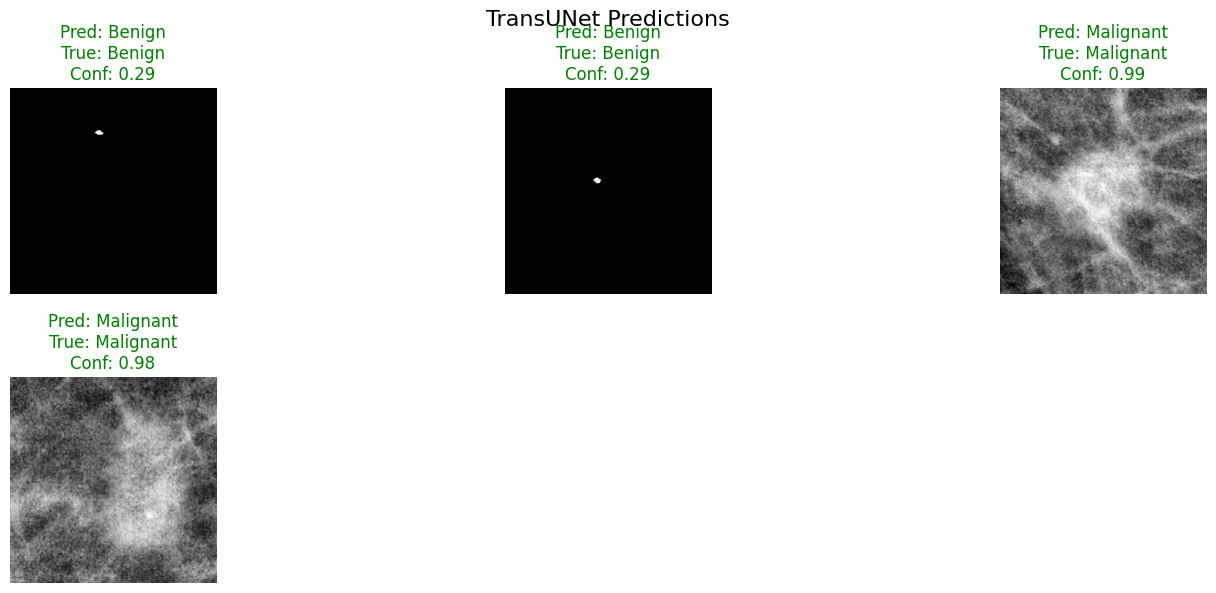

In [81]:
# Visualize some predictions from the TransUNet model
y_true, y_pred = [], []
sample_imgs = []

# Get predictions for a batch
for imgs, labels in val_rgb.take(1):
    preds = transunet_model.predict(imgs)
    sample_imgs = imgs
    y_pred.extend(preds.ravel())
    y_true.extend(labels.numpy())

y_pred_bin = np.array(y_pred) > 0.5

plt.figure(figsize=(15,6))
for i in range(min(6, len(y_pred))):
    plt.subplot(2,3,i+1)
    plt.imshow(tf.squeeze(sample_imgs[i]), cmap='gray')
    pred = "Malignant" if y_pred_bin[i] else "Benign"
    true = "Malignant" if y_true[i]==1 else "Benign"
    color = "red" if pred != true else "green"
    plt.title(f"Pred: {pred}\nTrue: {true}\nConf: {y_pred[i]:.2f}", color=color)
    plt.axis('off')
plt.suptitle("TransUNet Predictions", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()